<a href="https://colab.research.google.com/github/befitz/Multi-Factor_Modeling/blob/main/Multi_Factor_Model_Technical_Indicators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multi-Factor Modeling with Technical Indicators:
Analysis of the relationship between technical indicators and equity risk premium

*Brynne Fitzgerald*


**Abstract:**

This project's objective is to analyze the effectiveness of using technical indicators to identify excess returns. This project will focus on a specific asset class, Exchange Traded Funds (ETFs) and use historic prices to generate three common indicators; Bollinger Bands, MACD, and RSI. Each technical indicator effeciveness will be evaluated using the Fama-French 3-Factor model.

##Install & Import libraries
* ta-lib for calculating the technical indicators
* yfinance for import of historical price data

In [ ]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
!pip install yfinance

Selecting previously unselected package libta-lib0.
(Reading database ... 155629 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 269 kB 9.0 MB/s 
  Created wheel for ta-lib: filename=TA_Lib-0.4.24-cp37-cp37m-linux_x86_64.whl size=1465740 sha256=9fa9810492f415a04cecab16780b2b581f96dcfc91d7bd05d3cabd491ad4cd6a
  Stored in directory: /root/.cache/pip/whee

In [ ]:
from pandas_datareader import DataReader
from pandas_datareader import data as web
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
from statsmodels.formula.api import ols
import math
import yfinance as yf
import talib
from talib import MA_Type #moving average type required for Bollinger Bands

from statsmodels.tsa.stattools import adfuller #For checking stationarity


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

##Data Collection & Creation

###Import ETF price data

**Source:** Yahoo Finance via pandasDataReader

**2022 update** yfinance to source historical prices - documentation: https://pypi.org/project/yfinance/

ETF for this project: **TQQQ**

About TQQQ:

*   Leveraged ProShares ETF seeks return that is 3x the daily performance of the Nasdaq-100 Index
*   Net assets of $9.63 billion
*   Top holdings: Apple inc., Microsoft Corp. , Amazon.com Inc
*   Top Index sectors: Information Technology, Consumer Discretionary, Communication Services

TQQQ Fact sheet: https://www.proshares.com/media/fact_sheet/ProSharesFactSheetTQQQ.pdf?param=1618880582637

Addition ETFs with significant results: QQQ, VWO, VO



In [ ]:
def fetch_historical_prices(ticker, period="3y", interval= "1d"):
  """
  Function to use yfinance module to get the historical price history of a given ticker
  args: ticker (string), period <defaults to 3 years> (string), interval <default to daily>(string)
  returns: price_hist (pd.DataFrame)
  """
  tick = yf.Ticker(f"{ticker}")
  price_hist = tick.history(period=period, interval=interval)

  return price_hist

In [ ]:
ticker = 'TQQQ'
df = fetch_historical_prices(ticker, period="5y", interval = "1d")

In [ ]:
df.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-05-24,8.518213,8.573932,8.451684,8.563952,32470800,0.0,0.0
2017-05-25,8.657924,8.845037,8.603870,8.789319,43752000,0.0,0.0
2017-05-26,8.782666,8.835890,8.749402,8.826742,27428400,0.0,0.0
2017-05-30,8.805119,8.877470,8.795972,8.845037,27596400,0.0,0.0
2017-05-31,8.925704,8.944830,8.699504,8.834226,48451200,0.0,0.0


In [ ]:
df.shape

(1259, 7)

#Technical Indicators

Calculations explained below were gererated using the TaLib module


*   Ta-Lib documentation: https://cryptotrader.org/talib



##Bollinger Bands (BB)

About:


*   Created by John Bollinger in 1980s
*   Volatility indicator plotted at a standard deviation level above and below the close price.

Calculation:

*   Calculate the TEMA (Triple Exponential Moving Average) *SMA is also commonly used*
*   Calculate the standard deviation based on the TEMA

*   Upper Band = $\bar{x}$ + 2 $\sigma\$

*   Lower Band = $\bar{x}$ - 2 $\sigma\$

Strategy:

*   Long: When Price < Lower Band
*   Short: When Price is > Upper Band


In [ ]:
#Create Bollinger Bands using talib
def create_bb_signal(df):
  """
  Function to create a dataframe from the upper,middle, and lower data from talib
  args: df (pd.DataFrame of the asset price history)
  returns signal (pd.DataFrame)
  """
  upper, middle, lower = talib.BBANDS(df['Close'], matype=MA_Type.T3)
  signal = pd.DataFrame()
  signal['upper'] = upper
  signal['middle'] = middle
  signal['lower'] = lower
  signal['Close'] = df['Close']
  signal = signal.dropna()

  return signal


def BBbuy_sell(signal):
  """
  Function to signal when to buy/sell/hold
  Long and hold will be a 1 flag, short will be 0
  args: signal (pd.DataFrame)
  """
  flag = 0 #to track holdings, 1 for holding, 0 for not holding
  sig = [] #sig will be 1 for buy and 0 for sell
  sigPriceBuy = []
  sigPriceSell = []
  for i in range(0,len(signal)):
      if signal['Close'][i] > signal['upper'][i]: #if price is > upper then sell
        if flag != 1: #if there are no holdings, then do not sell
          sigPriceBuy.append(np.nan)
          sigPriceSell.append(np.nan)
          sig.append(0)
        else: #we have holdings at flag=1, we need to sell
          sigPriceBuy.append(np.nan)
          sigPriceSell.append(signal['Close'][i])
          sig.append(0)
          flag = 0
      elif signal['Close'][i] < signal['lower'][i]:  #if price is < lower then buy
        if flag != 0: #if there are holdings, we hold
          sigPriceSell.append(np.nan)
          sigPriceBuy.append(np.nan)
          sig.append(1)
        else:
          sigPriceSell.append(np.nan)
          sigPriceBuy.append(signal['Close'][i])
          sig.append(1)
          flag = 1
      else: #Handling nan values
        sigPriceSell.append(np.nan)
        sigPriceBuy.append(np.nan)
        sig.append(0)

  return (sigPriceBuy, sigPriceSell, sig)
  del (sigPriceBuy, sigPriceSell, sig)

In [ ]:
def BBdf_create(df):
  BBdf = create_bb_signal(df)
  BB = BBbuy_sell(BBdf)
  BBdf['Buy_Signal_Price'] = BB[0]
  BBdf['Sell_Signal_Price'] = BB[1]
  BBdf['BBsignal'] = BB[2]

  return BBdf

In [ ]:
#Data Visulization

def historical_signal_visualization(signal_df, signal_name):
  """
  Function to plot the closing price history of the security with buy/sell signals
  args: signal_name (string)
  """
  title = f'Close Price History Long/Short with {signal_name} Signals'
  plt.figure(figsize=(24,8))
  plt.scatter(signal_df.index, signal_df['Buy_Signal_Price'], color = 'green', label='Buy Signal', marker = '^', alpha = 1)
  plt.scatter(signal_df.index, signal_df['Sell_Signal_Price'], color = 'red', label='Sell Signal', marker = 'v', alpha = 1)
  plt.plot( signal_df['Close'],  label='Close Price', alpha = 0.35)
  plt.xticks(rotation=45)
  plt.title(title)
  plt.xlabel('Date',fontsize=18)
  plt.ylabel('Close Price USD ($)',fontsize=18)
  plt.legend( loc='upper left')
  plt.show()


def plot_BB_indicator(signal_df, signal_name):
  """
  Function to provide a visulization of the indicator
  args: signal_name (string)
  """
  plt.figure(figsize=(24,8))
  plt.plot(signal_df['upper'], color = 'green', linewidth = .5, alpha = .75)
  plt.plot(signal_df['Close'], color = 'blue',linewidth = .5, alpha = .75)
  plt.plot(signal_df['lower'], color ='red', linewidth = .5, alpha = .75)
  plt.title(f'{signal_name}')
  plt.show()

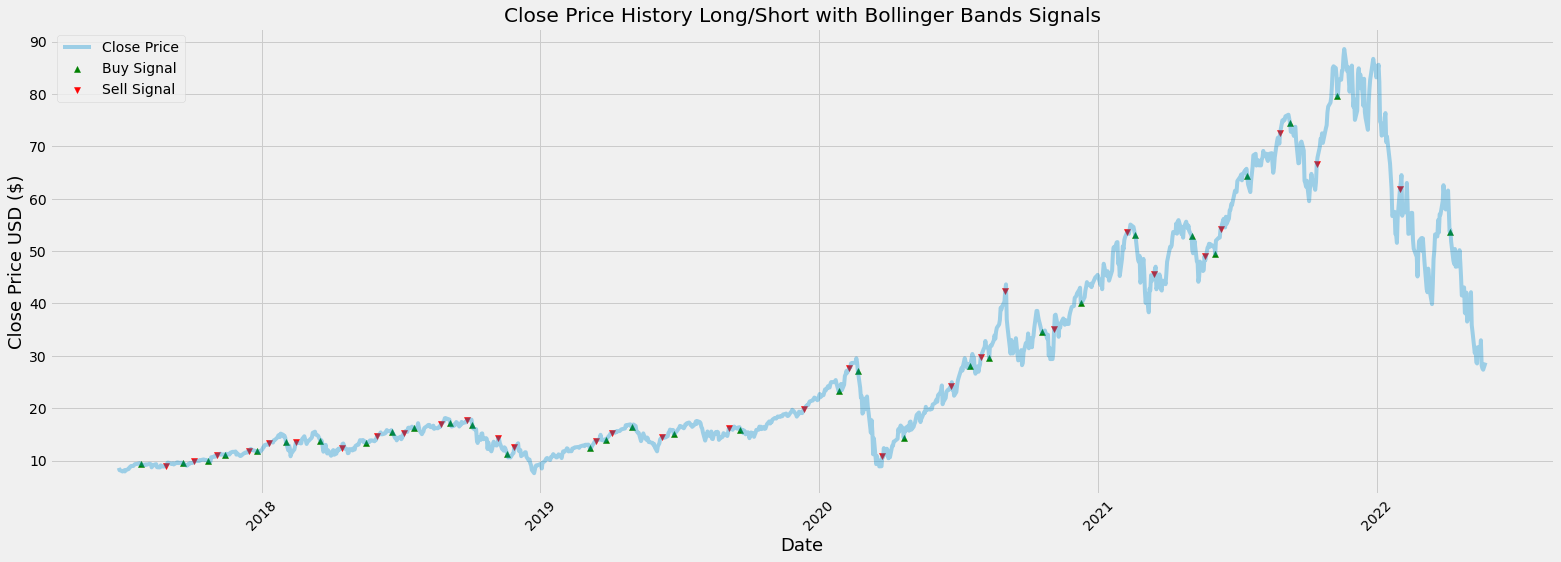

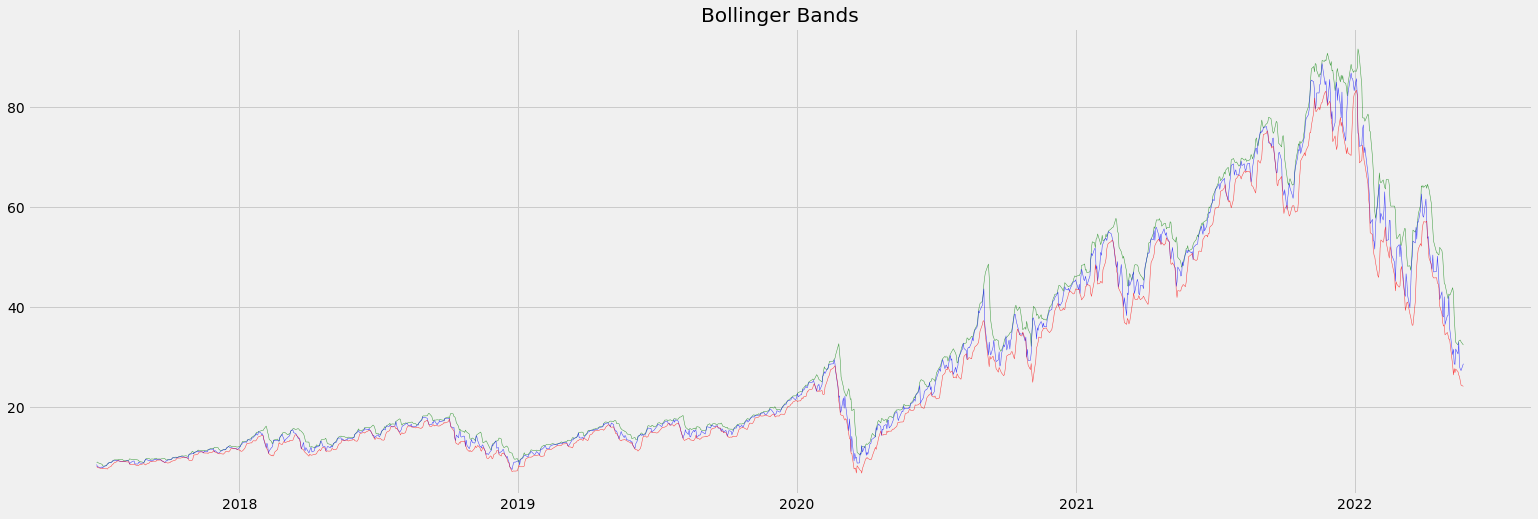

In [ ]:
BBdf = BBdf_create(df)
historical_signal_visualization(BBdf,"Bollinger Bands")
plot_BB_indicator(BBdf,"Bollinger Bands")

##Moving Average Convergence - Divergence (MACD)

About:


*   Created by Gerald Appel in 1970s
*   Trend following indicator which utilizes the exponetial moving average (EMA) technique


EMA Calculation:


*   $EMA_{today} = (Close Price_{today} - EMA_{yesterday}) * multiplier + EMA_{yesterday} $

> *   Where $mulitplier = \frac{2}{Days+1}$

*   The MACD line is constructed by subtracting a long-term EMA (usually 26 periods) by the short-term EMA (usually 12 periods)
* The MACD line is then compared with the "signal line" which is the EMA of the MACD (usually 9 periods)

Strategy:

*   Long: $MACD_t > Signal_t$
*   Short: $MACD_t < Signal_t$



In [ ]:
def create_macd_signal(df):
  """
  Function to create MACD signal from TAlib and output in a pd.DataFrame format
  args: df (pd.DataFrame)
  returns: MACD_signal (pd.DataFrame)
  """
  df['CloseLag1'] = df['Close'].shift(-1)
  macd, macdsignal, macdhist = talib.MACD(df['CloseLag1'], fastperiod=9, slowperiod=26, signalperiod=7) #using standard fast, slow, signal period lengths
  MACD_signal = pd.DataFrame()
  MACD_signal['macd'] = macd
  MACD_signal['macdsignal'] = macdsignal
  MACD_signal['macdhist'] = macdhist
  MACD_signal['Close'] = df['Close']
  MACD_signal = MACD_signal.dropna()

  return MACD_signal


def MACDbuy_sell(signal):
  """
  Function to singal buy/sell/hold for MACD Technical indicator
  args: signal (pd.DataFrame)
  returns: sigPriceBuy, sigPriceSell, sig (lists)
  """
  flag = 0
  sig = []
  sigPriceBuy = []
  sigPriceSell = []
  for i in range(0,len(signal)):
      if signal['macd'][i] > signal['macdsignal'][i]: #if MACD > signal line  then buy else sell
        if flag != 1:
          sigPriceBuy.append(signal['Close'][i])
          sigPriceSell.append(np.nan)
          sig.append(1)
          flag = 1
        else:
          sigPriceBuy.append(np.nan)
          sigPriceSell.append(np.nan)
          sig.append(1)
          flag = 1
      elif signal['macd'][i] < signal['macdsignal'][i]:
        if flag != 0:
          sigPriceSell.append(signal['Close'][i])
          sigPriceBuy.append(np.nan)
          sig.append(0)
          flag = 0
        else:
          sigPriceSell.append(np.nan)
          sigPriceBuy.append(np.nan)
          sig.append(0)
          flag = 0
      else: #Handling nan values
        sigPriceSell.append(np.nan)
        sigPriceBuy.append(np.nan)
        sig.append(0)

  return (sigPriceBuy, sigPriceSell, sig)
  del (sigPriceBuy, sigPriceSell, sig)


def MACDdf_create(df):
  """
  Function to tie the above two functions together and generate one dataframe
  args: df (pd.Dataframe)
  """
  MACDdf = create_macd_signal(df) #Create the MACD signal data
  MACD_signal_function = MACDbuy_sell(MACDdf)
  #the output of the MACD_signal_function are 3 lists, calling them by position here to populate a dataframe
  MACDdf['Buy_Signal_Price'] = MACD_signal_function[0]
  MACDdf['Sell_Signal_Price'] = MACD_signal_function[1]
  MACDdf['MACDsignal'] = MACD_signal_function[2]

  return MACDdf

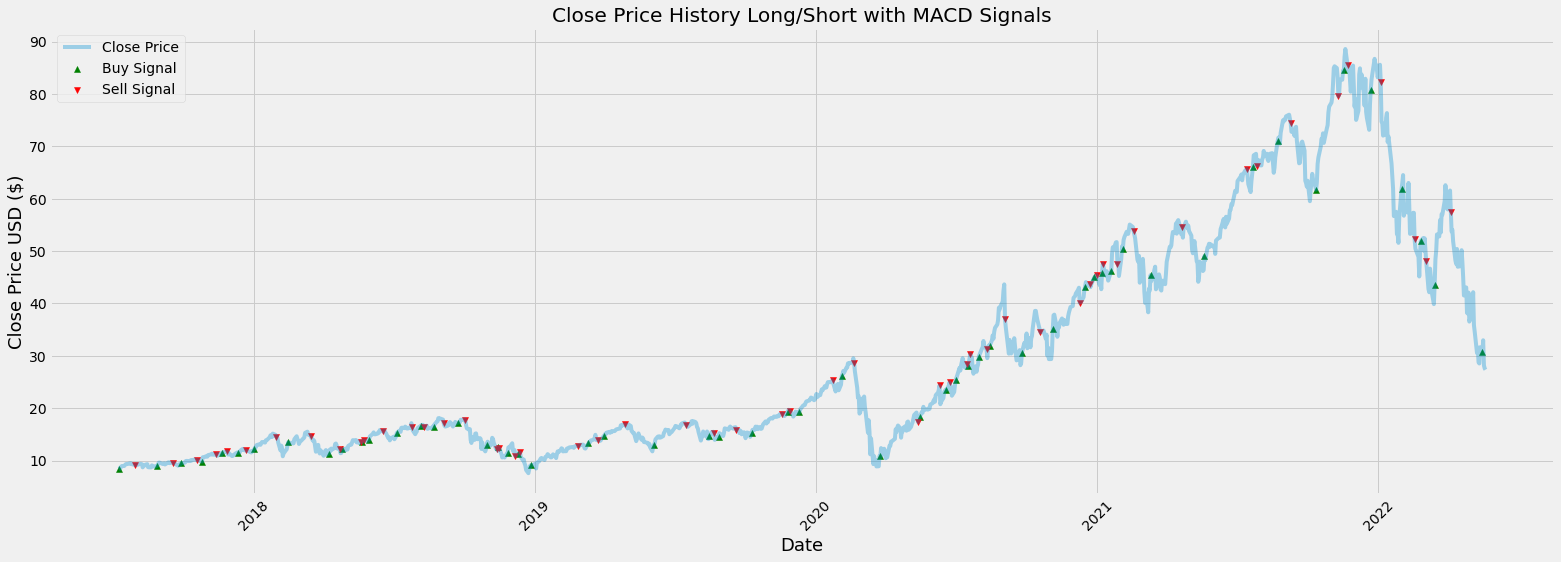

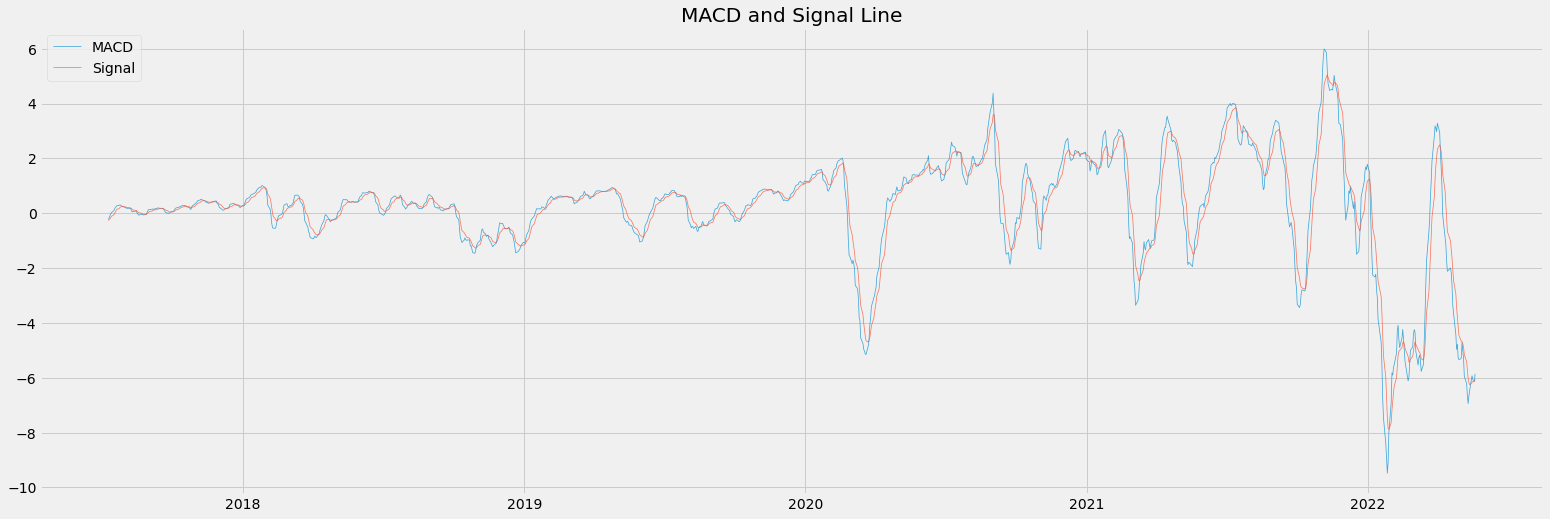

In [ ]:
MACDdf = MACDdf_create(df)
#Visualize the indicator
historical_signal_visualization(MACDdf,"MACD")

#Plot MACD indicator
plt.figure(figsize=(24,8))
plt.plot(MACDdf['macd'], label = 'MACD', linewidth = .75, alpha = .75)
plt.plot(MACDdf['macdsignal'], label = 'Signal', linewidth = .75, alpha = .75)
plt.title('MACD and Signal Line')
plt.legend( loc='upper left')
plt.show()

##Relative Strength Index (RSI)

About:

*   Created by J. Welles Wilder in 1978
*   Momentum Indicator which measures the impact of price changes to determine if the asset is overbought or oversold.

Calculation:


*   Calculate price change: $Change = Price_t - Price_{t-1}$
*   Create two variables for each period: one for the up moves and one for the down moves:
>* $If Change > 0, then:  Up_{move} = Change, else:  Up_{move} = 0$
>* $If Change < 0, then:  Down_{move} = Change, else:  Down_{move} = 0$
* Calculate the SMA of up move and down moves (usually 14 periods)

* $RSI = \frac{100}{\frac{Up Move Average}{Down Move Average}+1}$

Strategy:

* Long: $RSI_{t-1} < 30 and RSI_{t} > 30$
* Short: $RSI_{t-1} > 70 and RSI_{t} < 70$

In [ ]:
def create_rsi_indicator(df):
  """
  Function to create the RSI indicator from TAlib and format it into a pd.DataFrame
  args: df (pd.DataFrame)
  returns: RSIdf (pd.DataFrame)
  """
  rsi = talib.RSI(df['Close'],timeperiod=9)/100 #creates the indicator from TAlib
  RSIdf = pd.DataFrame()
  RSIdf['rsi'] = rsi
  RSIdf['Close'] = df['Close']
  RSIdf = RSIdf.dropna()

  return RSIdf


def RSIbuy_sell(signal):
  """
  Function to signal when to buy/sell/hold
  args: signal (pd.DataFrame)
  returns: rsiSigPriceBuy, rsiSigPriceSell, sig (lists)
  """
  flag = 0 #flag for tracking holding
  sig = [] #signal for tracking signal (1 buy, 0 sell or no action)
  rsiSigPriceBuy = []
  rsiSigPriceSell = []
  for i in range(0,len(signal)):
      if signal['rsi'][i-1] <= 0.30: #if previous day RSI is <= 30, consider buying if...
        if signal['rsi'][i] >= 0.30: #BUY if today's RSI is >=30
          if flag == 0:
            rsiSigPriceBuy.append(signal['Close'][i])
            rsiSigPriceSell.append(np.NaN)
            sig.append(1)
            flag = 1
          else: #if flag is 1, we are already holding so do nothing
            rsiSigPriceBuy.append(np.NaN)
            rsiSigPriceSell.append(np.NaN)
            sig.append(1)
            flag = 1
        else: #do nothing if RSI is still lower than 30
          rsiSigPriceBuy.append(np.NaN)
          rsiSigPriceSell.append(np.NaN)
          sig.append(flag)
          flag = flag
      elif signal['rsi'][i-1] >= 0.70: #if previous day RSI is >=70, consider selling if...
        if signal['rsi'][i] <= 0.70: #SELL if the RSI is retreating below 70
          if flag == 0:
            rsiSigPriceBuy.append(np.NaN)
            rsiSigPriceSell.append(np.NaN)
            sig.append(0)
            flag = 0
          else:
            rsiSigPriceBuy.append(np.NaN)
            rsiSigPriceSell.append(signal['Close'][i])
            sig.append(0)
            flag = 0
        else:
          rsiSigPriceBuy.append(np.NaN)
          rsiSigPriceSell.append(np.NaN)
          sig.append(flag)
          flag = flag
      else: #Handling nan values
        rsiSigPriceBuy.append(np.NaN)
        rsiSigPriceSell.append(np.NaN)
        sig.append(flag)

  return (rsiSigPriceBuy, rsiSigPriceSell, sig)


def create_RSIdf(df):
  """
  Function to tie together the above functions and create a single dataframe
  args: df (pd.DataFrame)
  """
  RSIdf = create_rsi_indicator(df)
  RSI = RSIbuy_sell(RSIdf)
  RSIdf['RSI_Buy_SigPrice'] = RSI[0]
  RSIdf['RSI_Sell_SigPrice'] = RSI[1]
  RSIdf['RSIsignal'] = RSI[2]

  return RSIdf

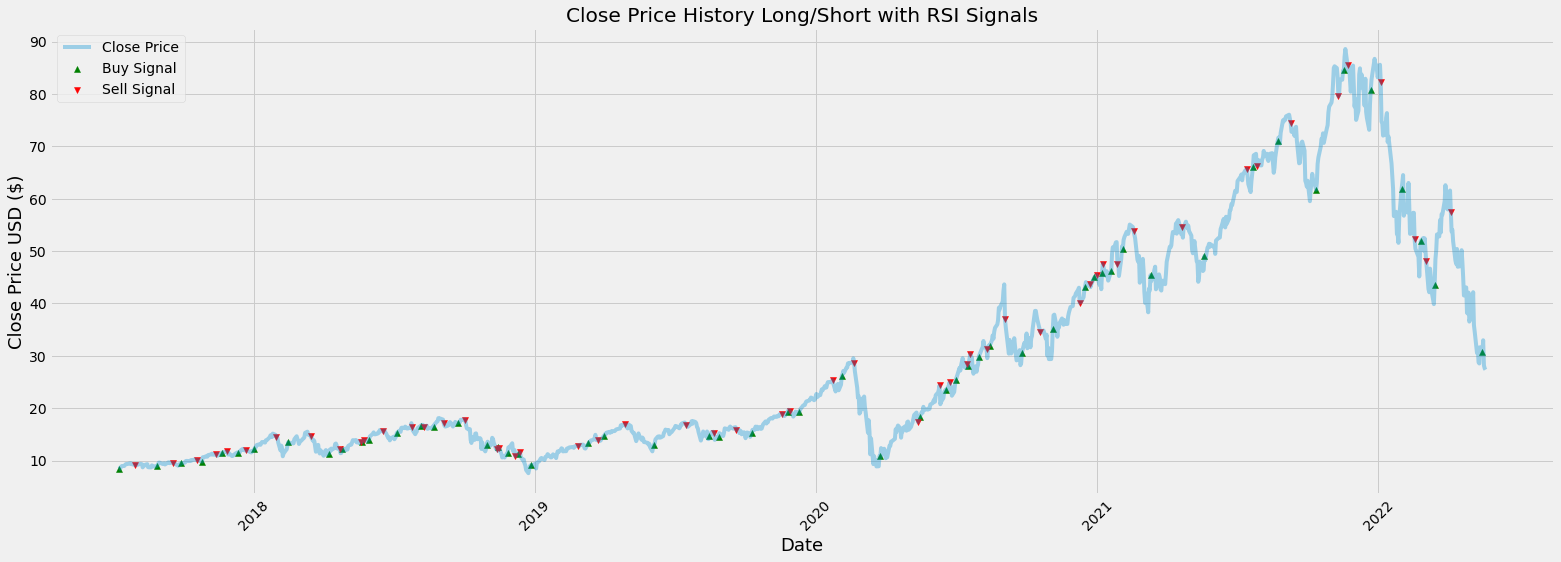

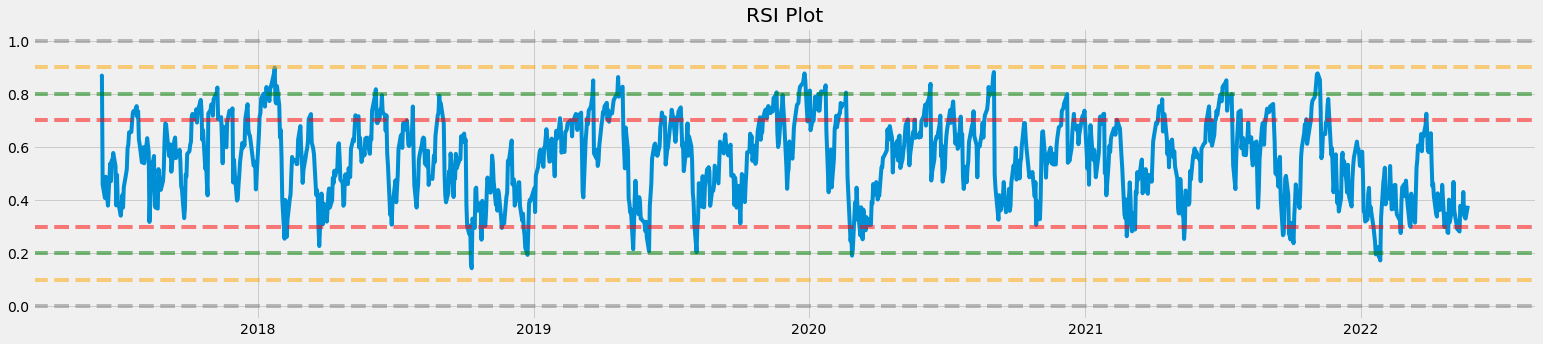

In [ ]:
RSIdf = create_RSIdf(df)
#Visualize the indicator
historical_signal_visualization(MACDdf,"RSI")


#Plot RSI indicator
plt.figure(figsize=(24,5)) #width = 24in, height = 8
plt.plot(RSIdf['rsi'])
plt.title('RSI Plot')
plt.axhline(0, linestyle = '--', alpha = 0.5, color='gray')
plt.axhline(.10, linestyle = '--', alpha = 0.5, color='orange')
plt.axhline(.20, linestyle = '--', alpha = 0.5, color='green')
plt.axhline(.30, linestyle = '--', alpha = 0.5, color='red')
plt.axhline(.70, linestyle = '--', alpha = 0.5, color='red')
plt.axhline(.80, linestyle = '--', alpha = 0.5, color='green')
plt.axhline(.90, linestyle = '--', alpha = 0.5, color='orange')
plt.axhline(1, linestyle = '--', alpha = 0.5, color='gray')
plt.show()

#Fama French 3-Factor Model


($R_{it} - RF_{ft} )= a_i + b_i (Mkt-RF) + s_iSMB + h_iHML + e_i$

Where:



*   $R_i$ is the daily return of the porfolio
*   $RF_t$ is the risk free rate


*   $Mkt-RF$ is the return spread between the capitalization weighted stock market and cash
*   $SMB$ is the return spread of small minus large stocks (i.e. the size effect)


*   $HML$ is the return spread of cheap minus expensive stocks (i.e. the value effect)


Factor data imported from Kenneth French's Data Library via Pandas DataReader


*   Fama-French Data documentation: https://pandas-datareader.readthedocs.io/en/latest/readers/famafrench.html
*   Kenneth French Data Library: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html


In [ ]:
def import_farma_french_model():
  """ Function to Import Fama French Three Factor Model Data"""
  ff_3_factor = web.DataReader('F-F_Research_Data_Factors_daily','famafrench')[0]
  ff_3_factor_df = pd.DataFrame(ff_3_factor)
  ff_3_factor_df = ff_3_factor_df.rename(columns={"Mkt-RF":"Mkt_RF"})#Change Mkt-RF to Mkt_RF

  #FF_factors are given as percentages, divide by 100
  ff_3_factor_df[['Mkt_RF', 'SMB', 'HML', 'RF']] = ff_3_factor_df[['Mkt_RF', 'SMB', 'HML', 'RF']]/100

  return ff_3_factor_df

ff_3_factor_df = import_farma_french_model()
ff_3_factor_df.head(5)

,Mkt_RF,SMB,HML,RF
Date,,,,
2017-05-25,0.0042,-0.0028,-0.0075,0.00003
2017-05-26,0.0006,-0.0003,0.0010,0.00003
2017-05-30,-0.0019,-0.0049,-0.0035,0.00003
2017-05-31,-0.0002,0.0004,-0.0053,0.00003
2017-06-01,0.0095,0.0101,0.0004,0.00003


In [ ]:
ff_3_factor_df.tail(5)

,Mkt_RF,SMB,HML,RF
Date,,,,
2022-03-25,0.0027,-0.0059,0.0217,0.0
2022-03-28,0.0073,-0.0055,-0.0169,0.0
2022-03-29,0.0145,0.0154,-0.0192,0.0
2022-03-30,-0.0083,-0.0128,0.0039,0.0
2022-03-31,-0.0155,0.0071,-0.0044,0.0


In [ ]:
def merge_all_data(df, MACDdf, RSIdf, BBdf, ff_3_factor_df):
  """
  Function to merge all signals and farma french model data into one dataframe
  to be used in the regression model
  """
  #Collect all indicators into one DataFrame
  all_indicators_df = pd.DataFrame()
  all_indicators_df[['MACDsignal', 'MACD_Buy_Price', 'MACD_Sell_Price']] = MACDdf[['MACDsignal', 'Buy_Signal_Price', 'Sell_Signal_Price']]
  all_indicators_df[['RSIsignal', 'RSI_Buy_Price', 'RSI_Sell_Price']] = RSIdf[['RSIsignal', 'RSI_Buy_SigPrice', 'RSI_Sell_SigPrice']]
  all_indicators_df[['BBsignal', 'BB_Buy_Price', 'BB_Sell_Price']] = BBdf[['BBsignal','Buy_Signal_Price', 'Sell_Signal_Price']]
  all_indicators_df['BBnMACDsignal'] = MACDdf['MACDsignal']*BBdf['BBsignal']
  all_indicators_df['Close'] = df['Close']
  all_indicators_df = all_indicators_df.fillna(0) #Fill NAs with 0s for all times where there are no buy or sell prices
  #merge all indicators dataframe with the farma french import
  ff_3_f_indicators = pd.merge(all_indicators_df, ff_3_factor_df, on='Date')

  return ff_3_f_indicators

In [ ]:
ff_3_f_indicators = merge_all_data(df, MACDdf, RSIdf, BBdf, ff_3_factor_df)
ff_3_f_indicators.describe()

,MACDsignal,MACD_Buy_Price,MACD_Sell_Price,RSIsignal,RSI_Buy_Price,RSI_Sell_Price,BBsignal,BB_Buy_Price,BB_Sell_Price,BBnMACDsignal,Close,Mkt_RF,SMB,HML,RF
count,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.00000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000
mean,0.567953,1.248947,1.310249,0.330537,0.261013,0.277257,0.061242,0.681755,0.692717,0.00755,29.037731,0.000628,-0.000046,-0.000139,0.000040
std,0.495569,7.158090,7.534220,0.470604,3.390401,3.648713,0.239874,5.249564,5.208303,0.08660,21.279949,0.012985,0.006879,0.010574,0.000037
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,7.581817,-0.120000,-0.035400,-0.049600,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,13.475666,-0.003800,-0.003900,-0.005100,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,17.125433,0.001000,-0.000200,-0.000600,0.000040
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,44.158750,0.006700,0.003800,0.004600,0.000070
max,1.000000,84.510002,85.500000,1.000000,68.785004,70.639999,1.000000,79.535004,72.550003,1.00000,88.570000,0.093400,0.055300,0.067500,0.000100


## Testing the stationarity of the series

**Augmented Dickey-Fuller (ADF)** test to verify the series is stationary or not.

* Null Hypothesis: the time series is non-stationary
* Alternative Hypothesis: the time series is stationary


In [ ]:
def adfuller_test(price_series):
  """
  Function to test for statinarity using Augmented Dickey-Fuller
  args: price_series (pd.Series)
  """
  print('Dickey-Fuller Test: ')
  adftest = adfuller(price_series)
  adfoutput = pd.Series(adftest[0:4], index = ['Test Statistic', 'p-value', 'Lags Used', 'No. of Observations'])
  for key,value in adftest[4].items():
    adfoutput['Critical Value (%s)'%key] = value
  print(adfoutput)

adfuller_test(ff_3_f_indicators['Close'])

Dickey-Fuller Test: 
Test Statistic            -0.852964
p-value                    0.803067
Lags Used                 17.000000
No. of Observations     1174.000000
Critical Value (1%)       -3.435932
Critical Value (5%)       -2.864005
Critical Value (10%)      -2.568082
dtype: float64


p-value is > 0.05, fail to reject the null hypothesis. Hence, we can confirm that the series is non-stationary. To correct for this, the log difference of the returns will be used.

In [ ]:
def normalize_log_returns(ff_3_f_indicators):
  """
  Function to correct for the non-stationarity of the time-sereis by taking the log difference of a single lag
  args: ff_3_f_indicators (pd.DataFrame)
  """
  #Normalize Returns by taking the log of the risk-free Rate
  ff_3_f_indicators['RFreturns'] = ff_3_f_indicators['Close'] - ff_3_f_indicators['RF']
  #Log Risk Free Returns
  ff_3_f_indicators['ln_RFReturn'] = np.log(ff_3_f_indicators['RFreturns']) - np.log(ff_3_f_indicators['RFreturns'].shift(1))
  ff_3_f_indicators = ff_3_f_indicators.dropna()

  return ff_3_f_indicators

Now the series has been normalized using the log, testing here again the statonarity of the series

In [ ]:
ff_3f_normalized = normalize_log_returns(ff_3_f_indicators)
adfuller_test(ff_3f_normalized['ln_RFReturn'])

Dickey-Fuller Test: 
Test Statistic         -1.102346e+01
p-value                 5.908017e-20
Lags Used               8.000000e+00
No. of Observations     1.182000e+03
Critical Value (1%)    -3.435894e+00
Critical Value (5%)    -2.863988e+00
Critical Value (10%)   -2.568074e+00
dtype: float64


p-value is <0.05, the series is now stationary

In [ ]:
ff_3_f_indicators.describe()

,MACDsignal,MACD_Buy_Price,MACD_Sell_Price,RSIsignal,RSI_Buy_Price,RSI_Sell_Price,BBsignal,BB_Buy_Price,BB_Sell_Price,BBnMACDsignal,Close,Mkt_RF,SMB,HML,RF,RFreturns,ln_RFReturn
count,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.00000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1191.000000
mean,0.567953,1.248947,1.310249,0.330537,0.261013,0.277257,0.061242,0.681755,0.692717,0.00755,29.037731,0.000628,-0.000046,-0.000139,0.000040,29.037691,0.001633
std,0.495569,7.158090,7.534220,0.470604,3.390401,3.648713,0.239874,5.249564,5.208303,0.08660,21.279949,0.012985,0.006879,0.010574,0.000037,21.279977,0.045059
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,7.581817,-0.120000,-0.035400,-0.049600,0.000000,7.581717,-0.422591
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,13.475666,-0.003800,-0.003900,-0.005100,0.000000,13.475606,-0.014307
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,17.125433,0.001000,-0.000200,-0.000600,0.000040,17.125348,0.004439
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,44.158750,0.006700,0.003800,0.004600,0.000070,44.158750,0.023950
max,1.000000,84.510002,85.500000,1.000000,68.785004,70.639999,1.000000,79.535004,72.550003,1.00000,88.570000,0.093400,0.055300,0.067500,0.000100,88.570000,0.238927


###Heteroskedasticity Test
**Breusch-Pagan and White tests**
* Heteroskedasticity is indicated if p < 0.05
* These tests can also result in low p-values when the model is not heteroskedastic if the model is otherwise flawed (most commonly due to omitted variable bias)



In [ ]:
#fit the model
formula = 'ln_RFReturn ~ Mkt_RF + SMB + HML + MACDsignal'

MACD_ff_model = ols(formula = formula , data = ff_3f_normalized)
MACD3model_nonrobust = MACD_ff_model.fit()

#import the libraries for the heteroskedasticiyt tests
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white

variables = ff_3f_normalized[['Mkt_RF', 'SMB', 'HML', 'MACDsignal']]
white_test = het_white(MACD3model_nonrobust.resid,  MACD3model_nonrobust.model.exog)
bp_test = het_breuschpagan(MACD3model_nonrobust.resid, variables)

labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print("Breusch-Pagon Test:")
print(dict(zip(labels, bp_test)))
print("White Test:")
print(dict(zip(labels, white_test)))

Breusch-Pagon Test:
{'LM Statistic': 84.50364212633733, 'LM-Test p-value': 3.3166231694242888e-18, 'F-Statistic': 22.662935691157323, 'F-Test p-value': 4.626633230637289e-18}
White Test:
{'LM Statistic': 372.2649656741458, 'LM-Test p-value': 1.5901797588957753e-71, 'F-Statistic': 41.166306391856615, 'F-Test p-value': 1.6962070668606786e-86}


Heteroskedasticity is present. The model must adjust to correct for this.

### Autocorrelation

Autocorrelation represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals.

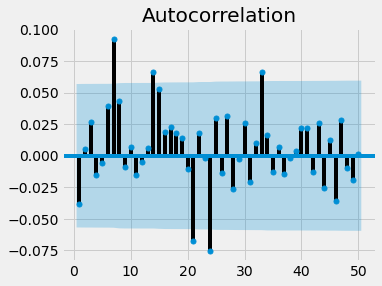

In [ ]:
#Visual test for Autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
e   = MACD3model_nonrobust.resid

fig = plt.figure(num = 1, figsize = (5, 4))
_ = plot_acf(e, lags = 50, zero = False, ax = fig.add_subplot(111))
plt.show()
#We can see from the plots that there are some sample autocorrelations which are statistically significantly different from zero
#(i.e. their values are above the blue horizontal line).

# Splitting the dataset



In [ ]:
df_train, df_test = ff_3f_normalized.iloc[:-math.floor(len(ff_3f_normalized)*.3)], ff_3f_normalized.iloc[-math.floor(len(ff_3f_normalized)*.3):]

In [ ]:
df_train

,MACDsignal,MACD_Buy_Price,MACD_Sell_Price,RSIsignal,RSI_Buy_Price,RSI_Sell_Price,BBsignal,BB_Buy_Price,BB_Sell_Price,BBnMACDsignal,Close,Mkt_RF,SMB,HML,RF,RFreturns,ln_RFReturn
Date,,,,,,,,,,,,,,,,,
2017-07-11,1,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,8.386819,0.0000,0.0036,-0.0055,0.00004,8.386779,0.008164
2017-07-12,1,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,8.685367,0.0072,0.0013,-0.0052,0.00004,8.685327,0.034978
2017-07-13,1,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,8.742748,0.0017,-0.0009,0.0038,0.00004,8.742708,0.006585
2017-07-14,1,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,8.948158,0.0042,-0.0012,-0.0051,0.00004,8.948118,0.023223
2017-07-17,1,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,8.953147,0.0000,0.0021,0.0011,0.00004,8.953107,0.000557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-23,0,0.0,0.0,0,0.0,0.0,1,0.0,0.0,0.0,34.825001,0.0038,0.0042,0.0005,0.00000,34.825001,0.005832
2020-10-26,0,0.0,0.0,0,0.0,0.0,1,0.0,0.0,0.0,33.237499,-0.0185,-0.0028,-0.0040,0.00000,33.237499,-0.046657
2020-10-27,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0.0,34.022499,-0.0023,-0.0006,-0.0236,0.00000,34.022499,0.023343


In [ ]:
df_test

,MACDsignal,MACD_Buy_Price,MACD_Sell_Price,RSIsignal,RSI_Buy_Price,RSI_Sell_Price,BBsignal,BB_Buy_Price,BB_Sell_Price,BBnMACDsignal,Close,Mkt_RF,SMB,HML,RF,RFreturns,ln_RFReturn
Date,,,,,,,,,,,,,,,,,
2020-10-30,0,0.00,0.0,0,0.0,0.000000,0,0.0,0.00,0.0,29.362499,-0.0145,-0.0079,0.0186,0.0,29.362499,-0.072093
2020-11-02,0,0.00,0.0,0,0.0,0.000000,0,0.0,0.00,0.0,29.372499,0.0117,0.0049,0.0102,0.0,29.372499,0.000341
2020-11-03,0,0.00,0.0,0,0.0,0.000000,0,0.0,0.00,0.0,30.850000,0.0193,0.0097,-0.0019,0.0,30.850000,0.049078
2020-11-04,1,35.02,0.0,0,0.0,0.000000,0,0.0,35.02,0.0,35.020000,0.0225,-0.0144,-0.0496,0.0,35.020000,0.126783
2020-11-05,1,0.00,0.0,0,0.0,0.000000,0,0.0,0.00,0.0,37.722500,0.0213,0.0099,0.0049,0.0,37.722500,0.074337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-25,1,0.00,0.0,1,0.0,0.000000,0,0.0,0.00,0.0,56.930000,0.0027,-0.0059,0.0217,0.0,56.930000,-0.001580
2022-03-28,1,0.00,0.0,1,0.0,0.000000,0,0.0,0.00,0.0,59.520000,0.0073,-0.0055,-0.0169,0.0,59.520000,0.044490
2022-03-29,1,0.00,0.0,1,0.0,0.000000,0,0.0,0.00,0.0,62.570000,0.0145,0.0154,-0.0192,0.0,62.570000,0.049974


# Extension to the FF model

($R_i - RF_t )= a_i + b_i (Mkt-RF) + s_iSMB + h_iHML + g_i Indicator + e_i$



*   Adding the sudo-variable, $Indicator$ which is 0 for short and 1 for long or hold

*   The logarithmic risk-free returns $(R_{it}-R_{ft})$ are used as the independent variable and calculated as follows:


$(R_{it}-R_{ft}) = ln((ClosingPrice_{t} - ClosingPrice_{t-1}) - RF_t)$


**Hypothesis:**

>*$H_0$ : The asset returns do not reflect positive sensitivity to the indicator

> $g_i Indicator < 0$

>*$H_1$ : The asset returns are positively sensitive to the indicator

>$g_i Indicator > 0$

In [ ]:
def ff3f_ols_regression(signal, ff_3f_normalized, summary=False):
  """
  Function that will use statsmodels ols to run the ols regression on the farma
  french and indicator data.
  args: signal (string), ff_3f_normalized (pd.DataFrame), summary (bool)
  """
  formula = f'ln_RFReturn ~ Mkt_RF + SMB + HML + {signal}'
  model = ols(formula = formula , data = ff_3f_normalized)
  model_hac = model.fit(cov_type = 'HAC', cov_kwds = {'maxlags':None}, use_t=True)

  if summary==False:
    return model_hac.pvalues, model_hac.rsquared_adj, model_hac.params
  else:
    print(model_hac.summary())


def trading_profit_results(signal, df, summary=False):
  """
  Function to print the number of buys, number of sells, and the net profit for the given time period
  """
  buys = df[df[f'{signal}_Buy_Price'] !=0]['ln_RFReturn'].count()
  sells = df[df[f'{signal}_Sell_Price'] !=0]['ln_RFReturn'].count()
  profit = df[f'{signal}_Sell_Price'].sum() - df[f'{signal}_Buy_Price'].sum()

  if summary==False:
    return buys, sells, profit
  else:
    print('Number of Buys: ', buys)
    print('Number of Sells: ', sells)
    print('Profit: $', profit)

##MACD Indicator FF3F Model

In [ ]:
ff3f_ols_regression('MACDsignal', df_train, summary=True)

                            OLS Regression Results                            
Dep. Variable:            ln_RFReturn   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     1083.
Date:                Tue, 24 May 2022   Prob (F-statistic):               0.00
Time:                        11:59:22   Log-Likelihood:                 2562.7
No. Observations:                 834   AIC:                            -5115.
Df Residuals:                     829   BIC:                            -5092.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0027      0.001     -4.685      0.0

In [ ]:
trading_profit_results('MACD', df_train, summary=True)

Number of Buys:  37
Number of Sells:  38
Profit: $ 75.8263635635376


In [ ]:
ff3f_ols_regression('MACDsignal', df_test, summary=True)

                            OLS Regression Results                            
Dep. Variable:            ln_RFReturn   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     1503.
Date:                Tue, 24 May 2022   Prob (F-statistic):          8.87e-220
Time:                        11:59:22   Log-Likelihood:                 1188.5
No. Observations:                 357   AIC:                            -2367.
Df Residuals:                     352   BIC:                            -2348.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0008      0.001     -1.229      0.2

In [ ]:
trading_profit_results('MACD', df_test, summary=True)

Number of Buys:  16
Number of Sells:  15
Profit: $ 5.564994812011719


##RSI Indicator FF3F Model

In [ ]:
ff3f_ols_regression('RSIsignal', df_train, summary=True)

                            OLS Regression Results                            
Dep. Variable:            ln_RFReturn   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     1142.
Date:                Tue, 24 May 2022   Prob (F-statistic):               0.00
Time:                        11:59:22   Log-Likelihood:                 2556.9
No. Observations:                 834   AIC:                            -5104.
Df Residuals:                     829   BIC:                            -5080.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0004      0.000     -1.063      0.2

In [ ]:
trading_profit_results('RSI', df_train, summary=True)

Number of Buys:  6
Number of Sells:  6
Profit: $ -1.6722192764282227


In [ ]:
ff3f_ols_regression('RSIsignal', df_test, summary=True)

                            OLS Regression Results                            
Dep. Variable:            ln_RFReturn   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     1271.
Date:                Tue, 24 May 2022   Prob (F-statistic):          9.45e-208
Time:                        11:59:22   Log-Likelihood:                 1187.8
No. Observations:                 357   AIC:                            -2366.
Df Residuals:                     352   BIC:                            -2346.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0002      0.001      0.411      0.6

In [ ]:
trading_profit_results('RSI', df_test, summary=True)

Number of Buys:  4
Number of Sells:  4
Profit: $ 21.034992218017578


##BB Indicator FF3F Model

Using HAC correction

In [ ]:
ff3f_ols_regression('BBsignal', df_train, summary=True)

                            OLS Regression Results                            
Dep. Variable:            ln_RFReturn   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     1259.
Date:                Tue, 24 May 2022   Prob (F-statistic):               0.00
Time:                        11:59:22   Log-Likelihood:                 2565.3
No. Observations:                 834   AIC:                            -5121.
Df Residuals:                     829   BIC:                            -5097.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0004      0.000     -1.041      0.2

In [ ]:
trading_profit_results('BB', df_train, summary=True)

Number of Buys:  24
Number of Sells:  23
Profit: $ -11.560094833374023


In [ ]:
ff3f_ols_regression('BBsignal', df_test, summary=True)

                            OLS Regression Results                            
Dep. Variable:            ln_RFReturn   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     1283.
Date:                Tue, 24 May 2022   Prob (F-statistic):          2.07e-208
Time:                        11:59:22   Log-Likelihood:                 1189.5
No. Observations:                 357   AIC:                            -2369.
Df Residuals:                     352   BIC:                            -2350.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0002      0.000      0.411      0.6

In [ ]:
trading_profit_results('RSI', df_test, summary=True)

Number of Buys:  4
Number of Sells:  4
Profit: $ 21.034992218017578


In [ ]:
def indicator_results_per_ticker(ff_3f_normalized):
  """
  args: ff_3f_normalized (pd.DataFrame) for one ticker
  returns: indicator_results (pd.DataFrame)
  """
  df_train, df_test = ff_3f_normalized.iloc[:-math.floor(len(ff_3f_normalized)*.3)], ff_3f_normalized.iloc[-math.floor(len(ff_3f_normalized)*.3):] #split the dataset

  indicators = ['MACD', 'RSI', 'BB']

  tas_dict = []
  for tas in indicators:
    dic = {}
    pvalues_train, rsquared_adj_trian, params_train = ff3f_ols_regression(f'{tas}signal', df_train, summary=False)
    train_buys, train_sells, train_profit = trading_profit_results(tas, df_train, summary=False)

    pvalues_test, rsquared_adj_test, params_test = ff3f_ols_regression(f'{tas}signal', df_test, summary=False)
    test_buys, test_sells, test_profit = trading_profit_results(tas, df_test, summary=False)
    dic['Indicator'] = tas

    dic['Intercept_train'] = round(params_train[0], 3)
    dic['Intercept p-value _train'] = round(pvalues_train[0], 3)
    dic['Signal _train'] = round(params_train[4],3)
    dic['Signal p-value _train'] = round(pvalues_train[4],3)
    dic['Adj_rsquared _train'] = round(rsquared_adj_trian,3)
    dic['Buys_train'] = train_buys
    dic['Sells_train'] = train_sells
    dic['profit_train'] = train_profit

    dic['Intercept_test'] = round(params_test[0], 3)
    dic['Intercept p-value _test'] = round(pvalues_test[0], 3)
    dic['Signal _test'] = round(params_test[4],3)
    dic['Signal p-value _test'] = round(pvalues_test[4],3)
    dic['Adj_rsquared _test'] = round(rsquared_adj_test,3)
    dic['Buys_test'] = test_buys
    dic['Sells_test'] = test_sells
    dic['profit_test'] = test_profit


    tas_dict.append(dic)

  indicator_results = pd.DataFrame(tas_dict)

  return indicator_results

In [ ]:
##All together
ff_3_factor_df = import_farma_french_model() #only needs to be done once

tickers_list = ['VWO', 'TQQQ', 'SCHX']
#'XLK', 'IVV', 'VTI', 'VOO', 'IWB'
results_dfs = []
for ticker in tickers_list:
  df = fetch_historical_prices(ticker, period="5y", interval = "1d")
  BBdf = BBdf_create(df)
  MACDdf = MACDdf_create(df)
  RSIdf = create_RSIdf(df)

  ff_3_f_indicators = merge_all_data(df, MACDdf, RSIdf, BBdf, ff_3_factor_df)
  ff_3f_normalized = normalize_log_returns(ff_3_f_indicators)
  indicator_results = indicator_results_per_ticker(ff_3f_normalized)
  indicator_results['Ticker'] = ticker
  results_dfs.append(indicator_results)

#final_results_df = pd.DataFrame(results_dicts)
final_result_df = pd.concat(results_dfs)
#final_results_df
final_result_df = final_result_df[['Ticker','Indicator', 'Signal _train', 'Signal p-value _train','Signal _test', 'Signal p-value _test',
                                     'Adj_rsquared _train', 'Adj_rsquared _test', 'profit_train', 'profit_test', 'Buys_train', 'Sells_train',
                                     'Buys_test', 'Sells_test']]


In [ ]:
final_result_df

,Ticker,Indicator,Signal _train,Signal p-value _train,Signal _test,Signal p-value _test,Adj_rsquared _train,Adj_rsquared _test,profit_train,profit_test,Buys_train,Sells_train,Buys_test,Sells_test
0,VWO,MACD,0.002,0.000,0.004,0.000,0.696,0.479,75.296040,-27.267479,37,38,17,16
1,VWO,RSI,-0.000,0.575,0.000,0.814,0.691,0.451,-6.914127,-45.414043,5,5,5,4
2,VWO,BB,-0.008,0.000,-0.010,0.000,0.708,0.491,-42.232296,40.483559,18,17,9,10
0,TQQQ,MACD,0.003,0.000,0.001,0.134,0.943,0.952,75.826365,5.564995,37,38,16,15
1,TQQQ,RSI,-0.001,0.120,-0.001,0.352,0.942,0.952,-1.672220,21.034992,6,6,4,4
2,TQQQ,BB,-0.007,0.000,-0.004,0.040,0.944,0.952,-11.560092,24.627502,24,23,7,8
0,SCHX,MACD,0.000,0.775,-0.000,0.922,0.996,0.995,34.679869,-33.677052,41,41,18,17
1,SCHX,RSI,-0.000,0.121,-0.000,0.156,0.996,0.995,-35.711985,43.482159,9,8,2,3
2,SCHX,BB,0.000,0.139,0.000,0.929,0.996,0.995,-42.220303,47.775543,17,16,9,10


# Conclusion
## MACD
The MACD pseudo-variable for the indicator results in a high R2 (0.928) which suggest that about 93% of the risk-free returns of the fund are explained by this model. The F-statistic is large and statistically significant. The model as a whole appears stable and ready for analysis of the results.

The intercept term, previously explained as the alpha excess returns, is statistically significant which suggests that not all excess returns are explained by these factors and indicator. The market beta coefficient (Mkt_RF) is 3.2118 this is in-line with the fund’s prospectus which is to provide fund returns 3x the market.

The SMB factor is sensitivity is negative and statistically significant This suggests the fund is more sensitive to large-cap stock price changes. This again, makes sense based on the prospectus since the fund exposure is of the 100 top performers of the Nasdaq. The HML factor is also statistically significant with a negative coefficient, which suggest the fund is negatively correlated to value stocks. The portfolio of TQQQ primarily holds growth stocks which is in-line with these results.

The MACD indicator is statistically significant with a t-statistic well above the rejection level of 2. As previously mentioned, the signal (or indicator) is a constructed pseudo-variable which is 1 for a long/buy, 1 for hold, and 0 for short/sell. The coefficient is positive in this result, therefore if the indicator were to be used and traded when a signal occurs, it will add up to a small amount of the total ETF return. The null hypothesis for the MACD indicator can be rejected and the alternative that the asset returns are positively sensitive to the indicator is accepted at the 99% confidence level.

## RSI
The OLS regression model for using RSI is also stable with a slightly lower R-squared, high F-statistic with p-value of 0. The alpha or intercept term is no longer significant in this model. The risk-free market beta, SMB, and HML are all generally the same conclusions as the ones stated for the MACD results.

This result fails to reject the null hypothesis since the RSI indicator is statistically insignificant based on the low t-test results and would otherwise be removed from this model.

It is worth noting that the RSI performed poorly in almost all ETFs I’ve regressed. Based on the results from this test, RSI is not a statistically significant indicator, but I think it is worth further testing to conclude if the insignificant result is due to the application of the signal or its performance (See general comments section 1 for additional comments on this).

##Bollinger Bands
The Bollinger Bands indicator performed the best in this model with the highest coefficient compared to RSI and MACD. The coefficient is positive with the value of 0.0048 with a t-value well above the rejection level of 2. I can reject the null hypothesis at the 99% confidence level and conclude that Bollinger Bands are the best of the 3 indicators for identifying excess returns for trading the ETF ticker TQQQ.

The results of the OLS regression are mixed based on the indicator used. I was able to reject the null hypothesis for MACD and Bollinger Band indicators. However, the RSI indicator does not reflect a statistically significant sensitivity in relation to this fund’s returns. Although only two of the three indicators tested in this model were statistically significant, these findings support motivation for further study.

#General Comments and Expansion


1.   Further testing and adjustment required for RSI indicator.
2.   Use additional factors to control for momentum (WML), profit (RWM), and firm/fund Investment style (CMA)
3.   Test additional indicators.
> * OBV (On Balance Volume)
> * Moving Averages (using SMA and EMA)
4.   Test combinations of indicators by muliplying the bivariate pseudo-variables.
> * MACD and BB
5.   Back-test the indicators or combination of indicators to provide evidence of the strategy's effectiveness.




##Fama-French 5 Factor Model


($R_{it} - RF_{ft} )= a_i + b_i(Mkt-RF) + s_iSMB + h_iHML + r_iRMW + c_iCMA + e_i$

Where:



*   $R_{it}$ is the daily return of the porfolio
*   $RF_{it}$ is the risk free rate
*   $Mkt-RF$ is the return spread between the capitalization weighted stock market and cash
*   $SMB$ is the return spread of small minus large stocks (i.e. the size effect)
*   $HML$ is the return spread of cheap minus expensive stocks (i.e. the value effect)
*   $RMW$ is the return spread of the most profitable firms minus least profitable
*   $CMA$ is the return spread of firms that invest conservatively minus aggressively




Extension to this model:

($R_{it} - RF_{ft} )= a_i + b_i (Mkt-RF) + s_iSMB + h_iHML + r_iRMW + c_iCMA + g_iIndicator + e_i$


Adding the sudo-variable, $Indicator$, which is 0 for short and 1 for long or hold

###FF5F Data Import

In [ ]:
ff_5_factor = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily','famafrench')[0]
ff_5_factor_df = pd.DataFrame(ff_5_factor)
ff_5_factor_df = ff_5_factor_df.rename(columns={"Mkt-RF":"Mkt_RF"})#Change Mkt-RF to Mkt_RF

In [ ]:
#FF_factors are given as percentages, divide by 100
ff_5_factor_df[['Mkt_RF', 'SMB', 'HML', 'RMW','CMA','RF']] = ff_5_factor_df[['Mkt_RF', 'SMB', 'HML', 'RMW','CMA','RF']]/100

#Normalize Returns by taking the log of the risk-free Rate
fundret['RFreturns'] = fundret['Close'] - ff_5_factor_df['RF']
#Log Risk Free Returns
ff_5_factor_df['ln_RFReturn'] = np.log(fundret['RFreturns']) - np.log(fundret['RFreturns'].shift(1))
ff_5_factor_df = ff_5_factor_df.dropna() #Drop NA values

In [ ]:
#Merge Indicators and ff_5_factordf
ff_5_factor1 = pd.merge(fundret, ff_5_factor_df , on='Date')
ff_5_factor2 = pd.merge(ff_5_factor1, MACDsignal, on = 'Date')
ff_5_factor3 = pd.merge(ff_5_factor2, BBsignal, on = 'Date')
ff_5_factor_df = pd.merge(ff_5_factor3, RSIsignal, on='Date')

####MACD FF5F

In [ ]:
#MACD
formula = 'ln_RFReturn ~ Mkt_RF + SMB + HML + RMW + CMA + MACDsignal'
MACDmodel5 = sm.ols(formula = formula , data = ff_3_f_indicators)

MACDmodel5_results = MACDmodel5.fit(cov_type = 'HAC', cov_kwds = {'maxlags':None}, use_t=True)
print(MACDmodel5_results.summary())

                            OLS Regression Results                            
Dep. Variable:            ln_RFReturn   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     783.0
Date:                Sun, 22 May 2022   Prob (F-statistic):          9.98e-303
Time:                        17:54:25   Log-Likelihood:                 2149.3
No. Observations:                 692   AIC:                            -4285.
Df Residuals:                     685   BIC:                            -4253.
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0016      0.001     -2.730      0.0

####RSI FF5F

In [ ]:
#RSI
formula = 'ln_RFReturn ~ Mkt_RF + SMB + HML + RMW + CMA + RSIsignal'
RSImodel5 = sm.ols(formula = formula , data = ff_3_f_indicators)

results = RSImodel5.fit(cov_type = 'HAC', cov_kwds = {'maxlags':None}, use_t=True)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            ln_RFReturn   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     835.5
Date:                Sun, 22 May 2022   Prob (F-statistic):          3.49e-311
Time:                        17:54:30   Log-Likelihood:                 2149.0
No. Observations:                 692   AIC:                            -4284.
Df Residuals:                     685   BIC:                            -4252.
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.177e-05      0.000     -0.026      0.9

####BB Indicator FF5F Model

In [ ]:
#BB
formula = 'ln_RFReturn ~ Mkt_RF + SMB + HML + RMW + CMA + BBsignal'

BBmodel5 = sm.ols(formula = formula , data = ff_3_f_indicators)

results = BBmodel5.fit(cov_type = 'HAC', cov_kwds = {'maxlags':None}, use_t=True)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            ln_RFReturn   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     823.3
Date:                Sun, 22 May 2022   Prob (F-statistic):          3.01e-309
Time:                        17:54:34   Log-Likelihood:                 2152.4
No. Observations:                 692   AIC:                            -4291.
Df Residuals:                     685   BIC:                            -4259.
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0003      0.000     -0.600      0.5